In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [2]:
%matplotlib inline

from importlib import reload

import os
import numpy as np

import pandas
import xarray
import h5py

import torch
from tqdm.auto import tqdm

from sklearn import neighbors

from matplotlib import pyplot as plt
import seaborn as sns
import umap

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.models import io as model_io
from ulmo.modis import io as modis_io
from ulmo.modis import analysis as analysis

## Show one cutout samples

In [3]:
### Load data locally
tbl_file = '/home/jovyan/modis_dataset/MODIS_L2_std.feather'
### Load the data from s3 bucket
# tbl_file = 's3://modis-l2/Tables/MODIS_L2_std.feather'
evals_tbl = ulmo_io.load_main_table(tbl_file)

Read main table: /home/jovyan/modis_dataset/MODIS_L2_std.feather


## Using Umap to reduce the dimension of Latents

In [4]:
### Load the latents file
lat_file = '/home/jovyan/modis_dataset/' \
           'MODIS_R2019_2019_95clear_128x128_latents_std.h5'
l_h5 = h5py.File(lat_file, 'r')
latents = l_h5['latents']
latents.shape

(751689, 512)

In [5]:
from Latents_toolbox import *

In [7]:
### At first let's get the index list of the latent vectors. Here we thank Prof. X for his nice 'matching' codes.
y2019 = evals_tbl.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2019_95clear_128x128_preproc_std.h5'
### Check the total number of the number of latents
assert np.sum(y2019) == latents.shape[0], 'The index list is not consistent with the latent array!'
print(f'The total number of latents is: {np.sum(y2019)}.')
### Get the index list of the latent vector
idx = evals_tbl[y2019].pp_idx.values
ll_pd = evals_tbl[y2019].LL
assert ll_pd.shape[0] == latents.shape[0], "The 'll' list is not consistent with the latent array!"

The total number of latents is: 751689.


In [8]:
alpha = 0.99
left_outlier_indices, right_outlier_indices, normal_indices = outliers_preparing(ll_pd, alpha)
print(f'number of left outliers is: {len(left_outlier_indices)}.')
print(f'number of right outliers is: {len(right_outlier_indices)}.')
print(f'number of normal points is: {len(normal_indices)}.')

number of left outliers is: 3759.
number of right outliers is: 3759.
number of normal points is: 744171.


In [9]:
num_normal = len(left_outlier_indices)
seed = 0 
np.random.seed(seed)
samples_normal_indices = np.random.choice(normal_indices, num_normal, replace=False).squeeze()
samples_normal_indices = np.sort(samples_normal_indices)

In [10]:
left_outlier_latents = latents[left_outlier_indices]
right_outlier_latents = latents[right_outlier_indices]
normal_latents = latents[samples_normal_indices]

In [11]:
latents_sampled = np.concatenate((left_outlier_latents, right_outlier_latents, normal_latents), axis=0)
print(f'shape of the sampled latents is: {latents_sampled.shape}.')

shape of the sampled latents is: (11277, 512).


In [12]:
ll_left_outliers = ll_pd.iloc[left_outlier_indices].values
ll_right_outliers = ll_pd.iloc[right_outlier_indices].values
ll_normal = ll_pd.iloc[samples_normal_indices].values
ll_sampled = np.concatenate((ll_left_outliers, ll_right_outliers, ll_normal), axis=0)
print(f'shape of the sampled ll is: {ll_sampled.shape}')

shape of the sampled ll is: (11277,)


In [13]:
n_neighbors = 200
min_dist = 0.3
n_components = 2
metric = 'euclidean'
title = f'min_dist is: {min_dist}'
parameters = {'n_neighbors': n_neighbors, 
              'min_dist': min_dist, 
              'n_components': n_components, 
              'metric': metric, 
              'title': title}

In [15]:
left_outlier_latents = latents[left_outlier_indices]
right_outlier_latents = latents[right_outlier_indices]
latents_part = np.concatenate((left_outlier_latents, right_outlier_latents), axis=0)
latents_part.shape[0]

7518

In [16]:
ll_part = np.concatenate((ll_left_outliers, ll_right_outliers), axis=0)

In [17]:
reducer = umap.UMAP(
          n_neighbors=n_neighbors,
          min_dist=min_dist,
          n_components=n_components,
          metric=metric)

In [18]:
%%time
reduced_latents = reducer.fit_transform(latents_part)

CPU times: user 11min 55s, sys: 1min 2s, total: 12min 58s
Wall time: 1min 11s


In [19]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.patches import Rectangle
from matplotlib.cbook import get_sample_data

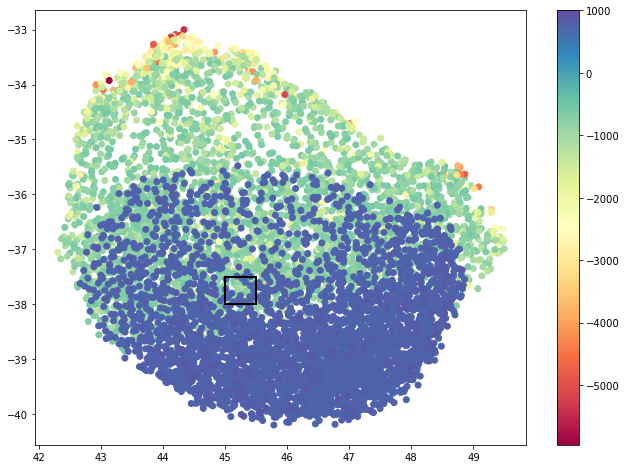

In [23]:
fig, ax = plt.subplots(figsize=(11, 8))
#ax.scatter(reduced_latents[3:left_size, 0], reduced_latents[3:left_size, 1], c=ll_sampled[3:left_size], 
#           cmap='Spectral')
plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=ll_part, cmap='Spectral')
plt.colorbar()

In [21]:
num_left = left_outlier_latents.shape[0]
num_right = right_outlier_latents.shape[0]

In [22]:
labels_left = np.zeros(num_left)
labels_right = np.ones(num_right)
labels_part = np.concatenate((labels_left, labels_right), axis=0)
assert labels_part.shape[0] == latents_part.shape[0], 'The result is not consistent!'

In [24]:
import sklearn.neighbors as neighbors

In [26]:
n_neighbors = 2
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(reduced_latents, labels_part)

KNeighborsClassifier(n_neighbors=2, weights='distance')

### Show the cutout of the latents with least cutout

In [222]:
indice_ll_least = np.argmin(ll_part)

In [223]:
latent_least = reduced_latents[indice_ll_least, :]

In [224]:
outliers_indices = np.concatenate((left_outlier_indices, right_outlier_indices), axis=0)

In [225]:
indice_ll_least = outliers_indices[indice_ll_least]

In [226]:
index_least = ll_pd.index[indice_ll_least]

In [227]:
cutout_M = evals_tbl.iloc[index_least]
img_modis = modis_io.grab_image(cutout_M)

In [228]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

<AxesSubplot:>

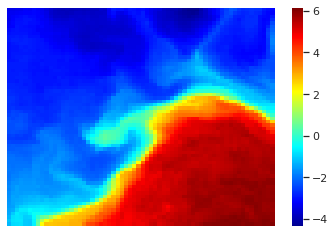

In [229]:
sns.heatmap(img_modis, xticklabels=[], yticklabels=[], cmap=cm, 
             cbar=True)

### Find the nearest neighborhoods

In [230]:
latent_least = np.expand_dims(latent_least, axis=0)
distance_list, neighbor_list = clf.kneighbors(latent_least, n_neighbors=10)

In [231]:
neighbor_list

array([[2757, 2416, 1272, 1968, 2792, 2945,  558, 3603, 2800, 1056]])

In [232]:
img_modis_list = []
for index in neighbor_list[0]:
    index_ll = outliers_indices[index]
    index_ll_pd = ll_pd.index[index_ll]
    cutout_M = evals_tbl.iloc[index_ll_pd]
    img_modis_list.append(modis_io.grab_image(cutout_M))

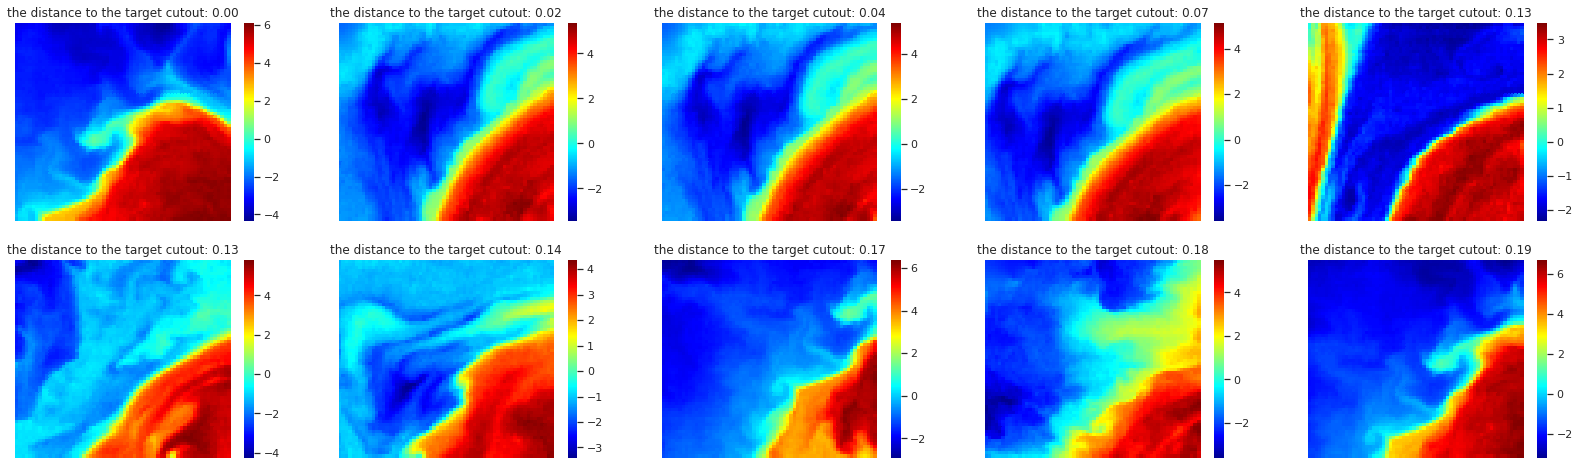

In [233]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(img_modis_list[i], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {distance_list[0][i]:.2f}')

### Scatter plot with cutouts

In [234]:
latents_list = [reduced_latents[i, :] for i in neighbor_list[0]]

In [235]:
x_latents_list = [latents_list[i][0] for i in range(10)]
y_latents_list = [latents_list[i][1] for i in range(10)]

In [236]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [237]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

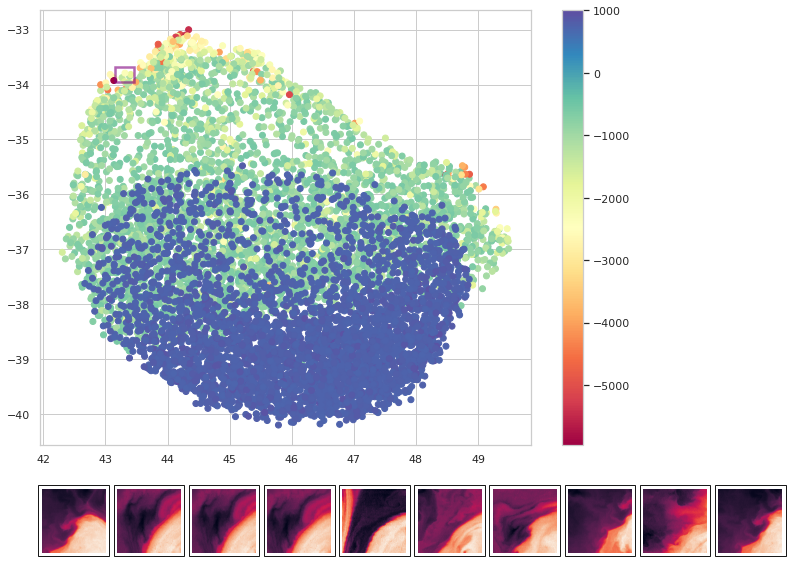

In [248]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
#ax.scatter(reduced_latents[3:left_size, 0], reduced_latents[3:left_size, 1], c=ll_sampled[3:left_size], 
#           cmap='Spectral')
plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=ll_part, cmap='Spectral')
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='purple',
                        lw = 2.5, 
                        alpha=0.6) )
plt.colorbar()
#####################################################################
### plot the cutouts
width, step = 73, 34.5 / 16
x_box, y_box = -40., -440.
ab_list = []
for i in range(5):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, ybox)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)
#y_box = y_box - width
for i in range(5, 10):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, ybox)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)

-------------------------------------------------------------------------------------------------------

### Show the cutout of the latents with the middle ll

<AxesSubplot:ylabel='Count'>

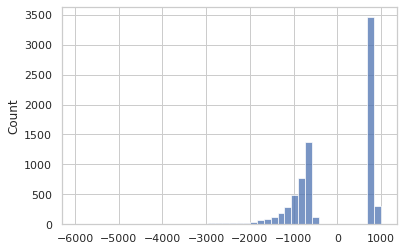

In [304]:
sns.histplot(ll_part)

In [329]:
indice_ll_middle = 15

In [330]:
latent_middle = reduced_latents[indice_ll_middle, :]

In [332]:
indice_ll_middle = outliers_indices[indice_ll_middle]

In [333]:
index_middle = ll_pd.index[indice_ll_middle]

In [334]:
cutout_M = evals_tbl.iloc[index_middle]
img_modis = modis_io.grab_image(cutout_M)

In [335]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

<AxesSubplot:>

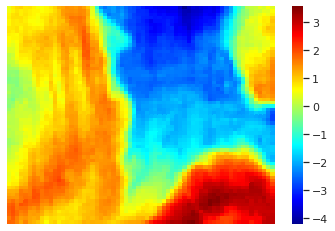

In [336]:
sns.heatmap(img_modis, xticklabels=[], yticklabels=[], cmap=cm, 
            cbar=True)

In [338]:
latent_middle = np.expand_dims(latent_middle, axis=0)
distance_list, neighbor_list = clf.kneighbors(latent_middle, n_neighbors=10)

In [339]:
neighbor_list

array([[  15,  826, 5324,  260, 1141, 3048,  294,  936, 3310, 1184]])

In [340]:
img_modis_list = []
for index in neighbor_list[0]:
    index_ll = outliers_indices[index]
    index_ll_pd = ll_pd.index[index_ll]
    cutout_M = evals_tbl.iloc[index_ll_pd]
    img_modis_list.append(modis_io.grab_image(cutout_M))

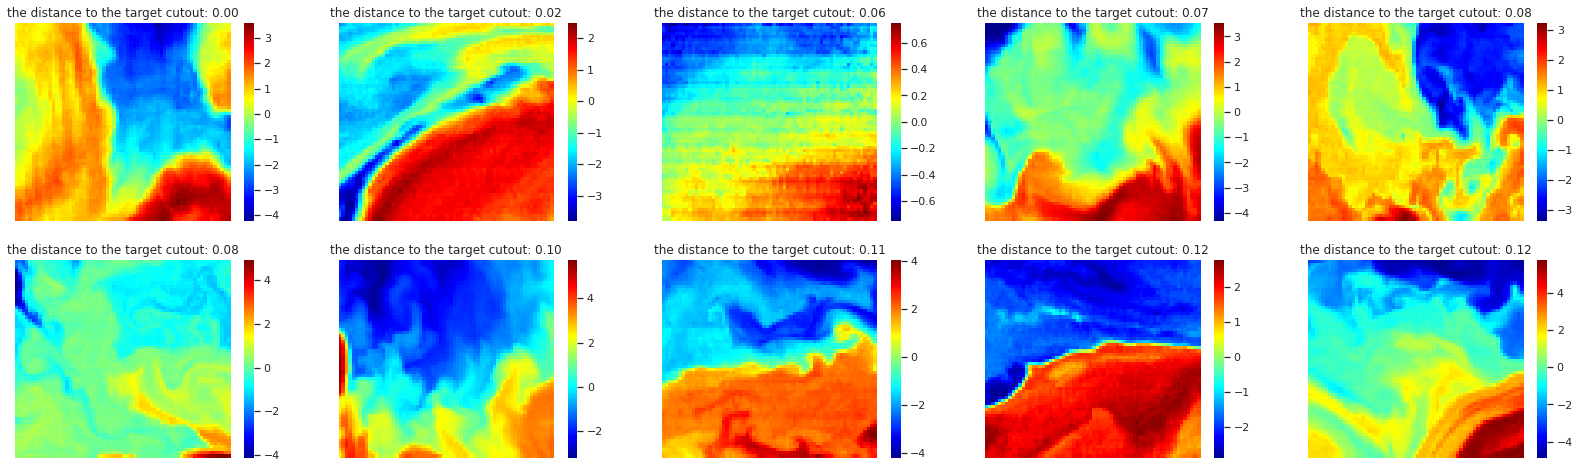

In [341]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(img_modis_list[i], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {distance_list[0][i]:.2f}')

In [342]:
latents_list = [reduced_latents[i, :] for i in neighbor_list[0]]

In [343]:
x_latents_list = [latents_list[i][0] for i in range(10)]
y_latents_list = [latents_list[i][1] for i in range(10)]

In [344]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [345]:
len_square = 3 * (x_max - x_min)
height_square = 3 * (y_max - y_min)
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

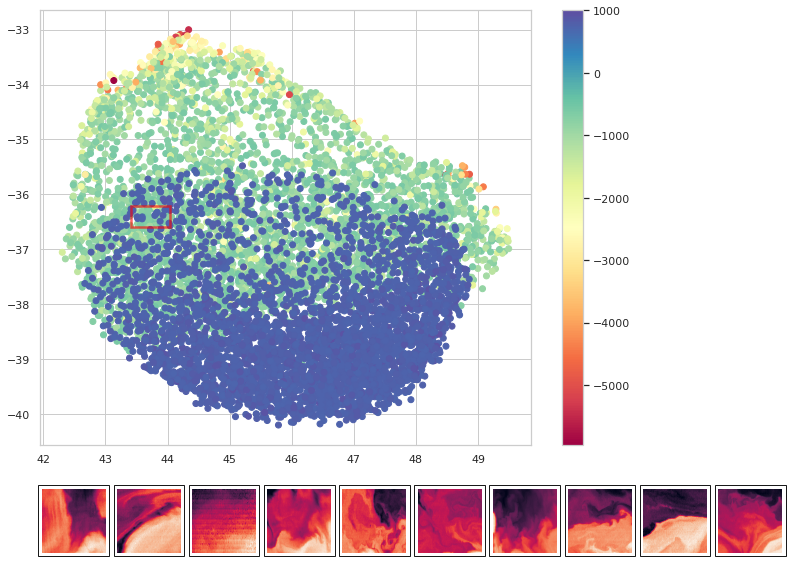

In [346]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
#ax.scatter(reduced_latents[3:left_size, 0], reduced_latents[3:left_size, 1], c=ll_sampled[3:left_size], 
#           cmap='Spectral')
plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=ll_part, cmap='Spectral')
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6) )
plt.colorbar()
#####################################################################
### plot the cutouts
width, step = 73, 34.5 / 16
x_box, y_box = -40., -440.
ab_list = []
for i in range(5):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, ybox)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)
#y_box = y_box - width
for i in range(5, 10):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, ybox)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)

### Show the LL and Similarity of the latents (Prof. X's similarity codes are used here.)

In [349]:
norm_latent = np.linalg.norm(reduced_latents.astype(float), axis=1)

In [354]:
normalized_latents = reduced_latents / np.outer(norm_latent, np.ones(2))

In [355]:
latents_target = normalized_latents[15]

In [358]:
sim_list = np.dot(normalized_latents, latents_target)

<AxesSubplot:ylabel='Count'>

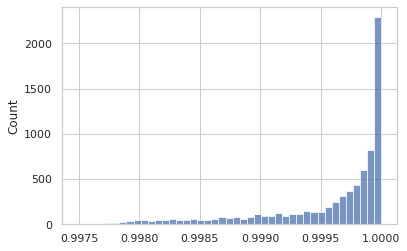

In [363]:
sns.histplot(sim_list)

### Show the cutout of the latents with highest cutout

In [387]:
indice_ll_max = np.argmax(ll_part)

In [365]:
latent_max = reduced_latents[indice_ll_max, :]

In [366]:
indice_ll_max = outliers_indices[indice_ll_max]

In [367]:
index_max = ll_pd.index[indice_ll_max]

In [368]:
cutout_M = evals_tbl.iloc[index_max]
img_modis = modis_io.grab_image(cutout_M)

In [369]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

<AxesSubplot:>

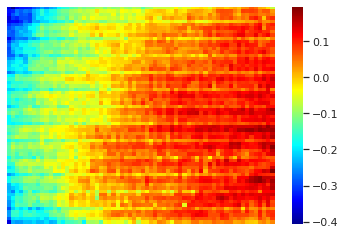

In [370]:
sns.heatmap(img_modis, xticklabels=[], yticklabels=[], cmap=cm, 
            cbar=True)

In [371]:
latent_max = np.expand_dims(latent_max, axis=0)
distance_list, neighbor_list = clf.kneighbors(latent_max, n_neighbors=10)

In [372]:
neighbor_list

array([[5166, 5851, 5566, 7281, 5957, 6528, 7228, 7363, 4208, 7503]])

In [373]:
img_modis_list = []
for index in neighbor_list[0]:
    index_ll = outliers_indices[index]
    index_ll_pd = ll_pd.index[index_ll]
    cutout_M = evals_tbl.iloc[index_ll_pd]
    img_modis_list.append(modis_io.grab_image(cutout_M))

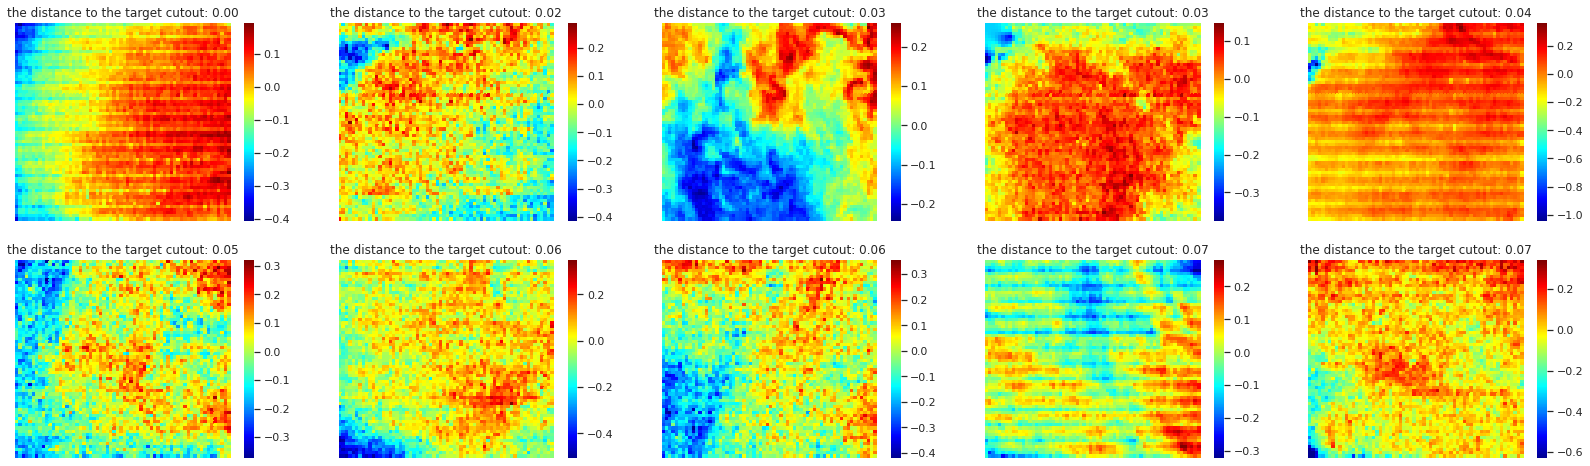

In [374]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(img_modis_list[i], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {distance_list[0][i]:.2f}')

In [375]:
latents_list = [reduced_latents[i, :] for i in neighbor_list[0]]

In [376]:
x_latents_list = [latents_list[i][0] for i in range(10)]
y_latents_list = [latents_list[i][1] for i in range(10)]

In [377]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [378]:
len_square = 3 * (x_max - x_min)
height_square = 3 * (y_max - y_min)
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

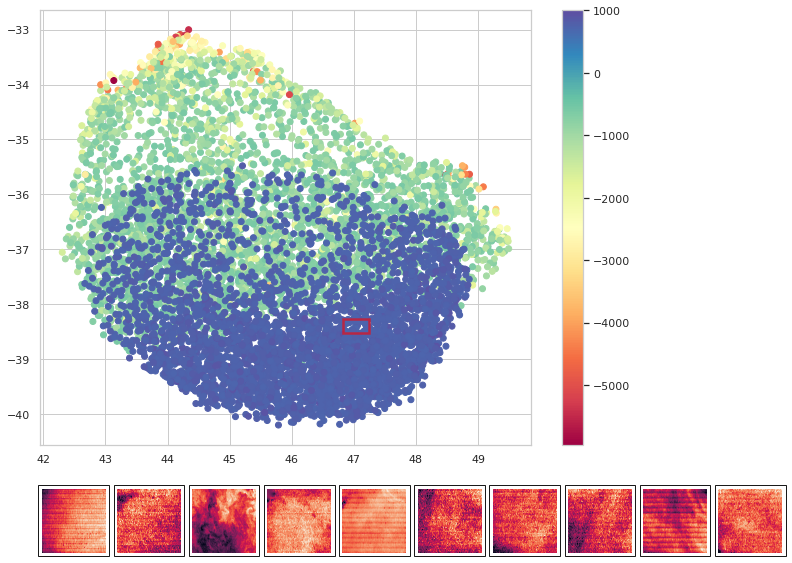

In [379]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
#ax.scatter(reduced_latents[3:left_size, 0], reduced_latents[3:left_size, 1], c=ll_sampled[3:left_size], 
#           cmap='Spectral')
plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=ll_part, cmap='Spectral')
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6) )
plt.colorbar()
#####################################################################
### plot the cutouts
width, step = 73, 34.5 / 16
x_box, y_box = -40., -440.
ab_list = []
for i in range(5):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, ybox)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)
#y_box = y_box - width
for i in range(5, 10):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, ybox)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)

### Show the LL and Similarity of the latents (Prof. X's similarity codes are used here.)

In [390]:
norm_latent = np.linalg.norm(reduced_latents.astype(float), axis=1)

In [391]:
normalized_latents = reduced_latents / np.outer(norm_latent, np.ones(2))

In [392]:
latents_target = normalized_latents[indice_ll_max]

In [393]:
sim_list = np.dot(normalized_latents, latents_target)

<AxesSubplot:ylabel='Count'>

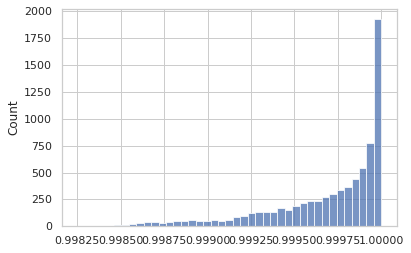

In [394]:
sns.histplot(sim_list)